In [1]:
import re
from tqdm import tqdm

import setup

In [2]:
#debug
setup.auth("test-algorithms")

"Testing algorithm 5(RSASHA1): 'OpenSSL RSA' ->'OpenSSL RSA' -> 'OpenSSL RSA' (2048 bits) Signature & verify ok, create 79241usec, signature 1222usec, verify 57usec\nTesting algorithm 7(RSASHA1-NSEC3-SHA1): 'OpenSSL RSA' ->'OpenSSL RSA' -> 'OpenSSL RSA' (2048 bits) Signature & verify ok, create 85702usec, signature 1238usec, verify 58usec\nTesting algorithm 8(RSASHA256): 'OpenSSL RSA' ->'OpenSSL RSA' -> 'OpenSSL RSA' (2048 bits) Signature & verify ok, create 86543usec, signature 1213usec, verify 56usec\nTesting algorithm 10(RSASHA512): 'OpenSSL RSA' ->'OpenSSL RSA' -> 'OpenSSL RSA' (2048 bits) Signature & verify ok, create 92750usec, signature 1098usec, verify 48usec\nTesting algorithm 13(ECDSAP256SHA256): 'OpenSSL ECDSA' ->'OpenSSL ECDSA' -> 'OpenSSL ECDSA' (256 bits) Signature & verify ok, create 28usec, signature 41usec, verify 125usec\nTesting algorithm 14(ECDSAP384SHA384): 'OpenSSL ECDSA' ->'OpenSSL ECDSA' -> 'OpenSSL ECDSA' (384 bits) Signature & verify ok, create 1776usec, signa

In [3]:
rexp = r"Testing algorithm (?P<alg_num>\d+)\((?P<alg_name>[a-zA-Z0-9\-]+)\): \'(?P<creator>[^\']*)\' ->\'(?P<signer>[^\']*)\' -> \'(?P<verifier>[^\']*)\' \((?P<alg_size>\d+) bits\) Signature \& verify ok, create (?P<time_create_usec>\d+)usec, signature (?P<time_sign_usec>\d+)usec, verify (?P<time_verify_usec>\d+)usec"
    
raw_data = [
    re.match(rexp, l).groupdict()
    for _ in tqdm(range(20))
    for l in setup.auth("test-algorithms").split("\n") if l
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:30<00:00, 40.54s/it]


In [4]:
import pandas as pd

In [5]:
data = pd.DataFrame(raw_data)
for c in ['alg_num', 'alg_size', 'time_create_usec', 'time_sign_usec', 'time_verify_usec']:
    data[c] = data[c].apply(int)
data

,alg_num,alg_name,creator,signer,verifier,alg_size,time_create_usec,time_sign_usec,time_verify_usec
0,5,RSASHA1,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,94418,1134,52
1,7,RSASHA1-NSEC3-SHA1,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,84388,1204,58
2,8,RSASHA256,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,89532,1247,59
3,10,RSASHA512,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,96195,1219,63
4,13,ECDSAP256SHA256,OpenSSL ECDSA,OpenSSL ECDSA,OpenSSL ECDSA,256,27,53,172
...,...,...,...,...,...,...,...,...,...
315,15,ED25519,Sodium ED25519,OpenSSL EDDSA,Sodium ED25519,256,46,62,119
316,15,ED25519,Sodium ED25519,Sodium ED25519,OpenSSL EDDSA,256,52,52,249
317,15,ED25519,Sodium ED25519,Sodium ED25519,Sodium ED25519,256,53,58,134
318,16,ED448,OpenSSL EDDSA,OpenSSL EDDSA,OpenSSL EDDSA,456,729,709,1493


In [6]:
mdata = data.melt(
    id_vars=['alg_num', 'alg_name', 'alg_size', 'creator', 'signer', 'verifier'], 
    value_vars=['time_create_usec', 'time_sign_usec', 'time_verify_usec'], 
    value_name='duration_usec'
)
mdata

,alg_num,alg_name,alg_size,creator,signer,verifier,variable,duration_usec
0,5,RSASHA1,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,94418
1,7,RSASHA1-NSEC3-SHA1,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,84388
2,8,RSASHA256,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,89532
3,10,RSASHA512,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,96195
4,13,ECDSAP256SHA256,256,OpenSSL ECDSA,OpenSSL ECDSA,OpenSSL ECDSA,time_create_usec,27
...,...,...,...,...,...,...,...,...
955,15,ED25519,256,Sodium ED25519,OpenSSL EDDSA,Sodium ED25519,time_verify_usec,119
956,15,ED25519,256,Sodium ED25519,Sodium ED25519,OpenSSL EDDSA,time_verify_usec,249
957,15,ED25519,256,Sodium ED25519,Sodium ED25519,Sodium ED25519,time_verify_usec,134
958,16,ED448,456,OpenSSL EDDSA,OpenSSL EDDSA,OpenSSL EDDSA,time_verify_usec,1493


In [7]:
mdata['action'] = mdata['variable'].apply(lambda v: v.split('_')[1])
mdata['library'] = mdata.apply(lambda row: row[{'create': 'creator', 'sign': 'signer', 'verify': 'verifier'}[row['action']]], axis=1)
mdata['library'] = mdata['library'].replace({'OpenSSL PQC': 'OQS/OpenSSL'})
mdata['library'] = mdata['library'].apply(lambda lib: lib.split(' ', 1)[0])
mdata['library'] = mdata['library'].replace({'OpenSSL': 'OQS/OpenSSL'})
mdata['algorithm'] = mdata.apply(lambda row: f"{row['alg_name']} {row['alg_size']}bits\n[{row['library']}]", axis=1)
mdata[['library', 'algorithm', 'action', 'duration_usec']]

,library,algorithm,action,duration_usec
0,OQS/OpenSSL,RSASHA1 2048bits\n[OQS/OpenSSL],create,94418
1,OQS/OpenSSL,RSASHA1-NSEC3-SHA1 2048bits\n[OQS/OpenSSL],create,84388
2,OQS/OpenSSL,RSASHA256 2048bits\n[OQS/OpenSSL],create,89532
3,OQS/OpenSSL,RSASHA512 2048bits\n[OQS/OpenSSL],create,96195
4,OQS/OpenSSL,ECDSAP256SHA256 256bits\n[OQS/OpenSSL],create,27
...,...,...,...,...
955,Sodium,ED25519 256bits\n[Sodium],verify,119
956,OQS/OpenSSL,ED25519 256bits\n[OQS/OpenSSL],verify,249
957,Sodium,ED25519 256bits\n[Sodium],verify,134
958,OQS/OpenSSL,ED448 456bits\n[OQS/OpenSSL],verify,1493


In [8]:
import seaborn as sns

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [9]:
ALGORITHM_COLORS = {
    'RSASHA1 2048bits\n[OQS/OpenSSL]': '#ff0000',
    'RSASHA1-NSEC3-SHA1 2048bits\n[OQS/OpenSSL]': '#dd0000',
    'RSASHA256 2048bits\n[OQS/OpenSSL]': '#bb0000',
    'RSASHA512 2048bits\n[OQS/OpenSSL]': '#990000',
    'ECDSAP256SHA256 256bits\n[OQS/OpenSSL]': '#00ff00',
    'ECDSAP384SHA384 384bits\n[OQS/OpenSSL]': '#00dd00',
    'ED25519 256bits\n[OQS/OpenSSL]': '#0000ff',
    'ED25519 256bits\n[Sodium]': '#0000dd',
    'ED448 456bits\n[OQS/OpenSSL]': '#0000bb',
    'falcon 10248bits\n[OQS/OpenSSL]': '#00ffff',
}
ALGORITHM_ORDER = list(ALGORITHM_COLORS.keys())
ALGORITHM_PALETTE = sns.color_palette([ALGORITHM_COLORS[a] for a in ALGORITHM_ORDER])

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


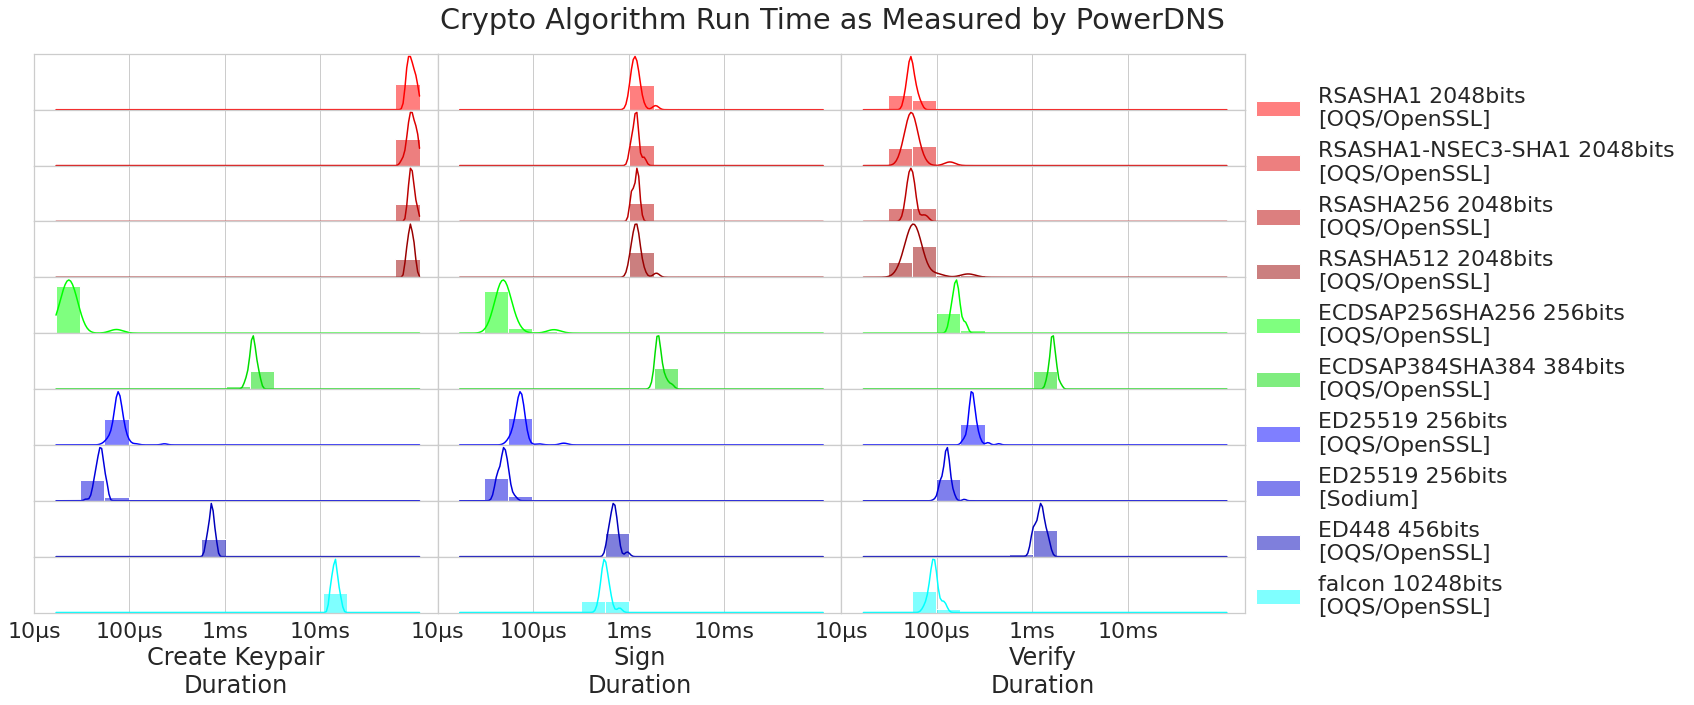

In [10]:
g = sns.displot(
    data=mdata,
    x='duration_usec',
    row='algorithm', col='action',
    hue='algorithm', hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    log_scale=(True, False),
    height=.9,
    aspect=6/.9,
    facet_kws=dict(legend_out=True, margin_titles=False, despine=False, sharey=False),
    kind='hist',
    kde=True,    
)
g.set(
    #xlim=(1*1e-3, 1e-1), 
    ylabel='', 
    yticks=[],
    xticks=[10, 100, 1000, 10000],
    xticklabels=["10µs", "100µs", "1ms", "10ms"],
    title='',
)

for ax, label in zip(g.axes[-1, :], ['Create Keypair', 'Sign', 'Verify']):
    ax.set_xlabel(f'{label}\nDuration')
    
g.figure.suptitle('Crypto Algorithm Run Time as Measured by PowerDNS', y=1.02)
g.figure.subplots_adjust(wspace=0, hspace=0)
g.legend.set_title('')
g.legend.set_zorder(1)
g.savefig('data/crypto_times_indv.pdf')